In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# **PART 1**

In [20]:
df = pd.read_csv("audit_risk.csv")
#print(df.info())

In [21]:
# Identify problematic rows
problematic_rows = df[~df['LOCATION_ID'].astype(str).str.isdigit()]

# print(problematic_rows)

df.loc[problematic_rows.index, 'LOCATION_ID'] = 0

df['LOCATION_ID'] = pd.to_numeric(df['LOCATION_ID'], errors='coerce').fillna(df['LOCATION_ID'])

df.dropna(inplace=True)

#df = df.drop(columns=['LOCATION_ID'])

X = df.drop(["Risk"], axis=1)
y = df["Risk"]

#X = X.select_dtypes(include=[np.number]).fillna(X.median())

In [22]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)  # Ensure X is a NumPy array
        predictions = []

        for x in X:
            distances = []
            for x_train in self.X_train:
                distance = np.sqrt(np.sum((x - x_train) ** 2)) # Euclidean distance between test point and training points
                distances.append(distance)

            indices_with_distances = list(range(len(distances)))  # Create a list of indices
            sorted_indices = sorted(indices_with_distances, key=lambda i: distances[i])  # Sort indices based on distances starting from closest distance
            k_indices = sorted_indices[:self.k]  # Take the indices until k

            k_nearest_labels = []
            for i in k_indices:
                label = self.y_train[i]  # Get the label corresponding to the index i
                k_nearest_labels.append(label)  # Append the label to the list of k nearest neighbor labels

            # Majority vote
            label_counts = {}
            for label in k_nearest_labels:
                if label in label_counts:
                    label_counts[label] += 1 # If there is corresponding label in list, increase it counts
                else:
                    label_counts[label] = 1 # If there is not, create as 1

            max_label = max(label_counts, key=label_counts.get) # Get the maximum counting label
            predictions.append(max_label)

        return predictions


In [23]:
def k_fold_cross_validation(X, y, k):
    num_of_samples = len(X)
    fold_size = num_of_samples // k

    indices = np.random.permutation(num_of_samples) # Shuffle data
    X_mixed = X[indices]
    y_mixed = y[indices]

    folds = []

    for i in range(k):
        # Split the data into training and test sets
        X_test = X_mixed[i * fold_size:(i + 1) * fold_size]
        y_test = y_mixed[i * fold_size:(i + 1) * fold_size]

        # Remaining ones are training
        X_train = np.concatenate([X_mixed[:i * fold_size], X_mixed[(i + 1) * fold_size:]])
        y_train = np.concatenate([y_mixed[:i * fold_size], y_mixed[(i + 1) * fold_size:]])

        folds.append((X_train, y_train, X_test, y_test))

    return folds

For each solution above, report the performance of training and testing for a
single fold of the 6-fold validation case.


RESULTS:


Accuracy for fold 1: 0.9767441860465116
Confusion matrix for fold 1:
[[81  1]
 [ 2 45]]

Accuracy for fold 2: 0.9767441860465116
Confusion matrix for fold 2:
[[77  0]
 [ 3 49]]

Accuracy for fold 3: 0.9457364341085271
Confusion matrix for fold 3:
[[81  0]
 [ 7 41]]

Accuracy for fold 4: 0.9612403100775194
Confusion matrix for fold 4:
[[74  0]
 [ 5 50]]

Accuracy for fold 5: 0.9689922480620154
Confusion matrix for fold 5:
[[78  1]
 [ 3 47]]

Accuracy for fold 6: 0.9689922480620154
Confusion matrix for fold 6:
[[76  0]
 [ 4 49]]

Final Accuracy: 0.9664082687338501
Final confusion matrix:
 [[76  0]
 [ 4 49]]


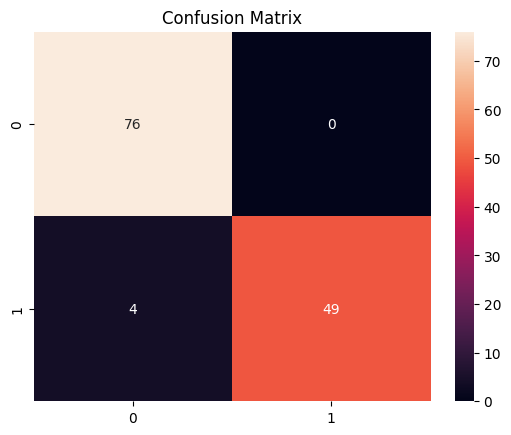


Runtime: 2.8601090908050537 seconds


In [24]:
start_time = time.time()

print("RESULTS:\n\n")

knn_model = KNNClassifier(k=3) # k=3 for testing
scores = []

# Apply cross validation for classification
folds = k_fold_cross_validation(X.values, y.values, 6)

for fold_idx, fold in enumerate(folds):
    X_train, y_train, X_test, y_test = fold
    knn_model.fit(X_train, y_train)
    predictions = knn_model.predict(X_test)
    accuracy = np.mean(predictions == y_test)
    scores.append(accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predictions)
    print(f"Accuracy for fold {fold_idx + 1}: {accuracy}")
    print(f"Confusion matrix for fold {fold_idx + 1}:\n{cm}\n")

final_accuracy = np.mean(scores)
print("Final Accuracy:", final_accuracy)

cm = confusion_matrix(y_test, predictions)
print("Final confusion matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

end_time = time.time()

# Report runtime performance
runtime = end_time - start_time
print("\nRuntime:", runtime, "seconds")

# **COMMENTS:**

I used audit_risk.csv data as a dataset for classification models.

\\
**Preprocess:**

In the audit_risk dataset, there were 3 object values. So, I couldn't include them while training.

First, I found problematic rows where the 'LOCATION_ID' column contains non-numeric values. Then, I set the 'LOCATION_ID' of these rows to 0. Also I dropped the null variables with dropna function.

Finally, I seperated X (input) and y (output), where "Risk" is the target variable.

\\
**KNN Classifier Implementation:**

It takes test data X as input and returns predictions for each data point in X. For each test data point x, the method computes the Euclidean distance between x and each data point in the training set X_train.

Based on these distances, it identifies the indices of the k nearest neighbors. It sorts them according to their distances until the given k value (`sorted_indices[:self.k]`). It then retrieves the corresponding labels from the training labels y_train.

A majority vote is performed among these labels to determine the predicted label for the test data point x by counting the labels in loop.

This process is repeated for all test data points, and the predictions are collected into a list, which is then returned.

\\
**K-Fold Implementation:**

 It begins by taking permutation of the dataset to ensure randomness.

 Then, it divides the data into k equally-sized folds. For each fold, it seperates the test data starting from `i x fold_size` until `(i+1) x fold_size` where the fold_size is the number of samples divided by k (6 in this project). Then, we take the remaining samples as training data. This process is repeated k times, ensuring that every data point (interval) is used for testing exactly once.

 The function returns a list of k tuples, each containing the training features, training labels, testing features, and testing labels.

\\
**Training and Testing:**

The final part performs k-fold cross-validation using my implementation, splitting the data into training and testing sets. Within the loop for each fold, it fits the KNN model to the training data, makes predictions on the testing data, calculates accuracy, and appends the accuracy to the scores list. I also calculated the confusion matrix for each fold.

After the loop, it calculates the final accuracy by taking the mean of all fold accuracies and prints it. Also, I calculated the confusion matrix and visualized it using seaborn's heatmap, and reported the runtime performance of the code.

So, when we look at the results we can see this is a very successful model. Because, its accuracy is 96% and also the FP and FN counts

 are very little.


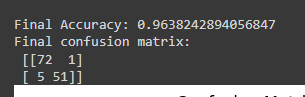

# **PART 2**


In [25]:
df_day = pd.read_csv("day.csv")

# print(df_day.info())

df_day = df_day.drop(columns=['dteday', 'instant'])

# print(df_day.info())

X = df_day.drop(["cnt"], axis=1)
y = df_day["cnt"]
# print(X)

In [26]:
class KNNRegressor:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)

    def predict(self, X):
        X = np.array(X)  # Ensure X is a NumPy array
        predictions = []

        for x in X:

            distances = []
            for x_train in self.X_train:
                distance = np.sum(np.abs(x - x_train))  # Manhattan distance between test point and training points
                distances.append(distance)

            indices_with_distances = list(range(len(distances)))  # Create a list of indices
            sorted_indices = sorted(indices_with_distances, key=lambda i: distances[i])  # Sort indices based on distances starting from closest distance
            k_indices = sorted_indices[:self.k]  # Take the first k indices

            k_nearest_labels = []  # Initialize an empty list to store the labels of k nearest neighbors
            for i in k_indices:
                label = self.y_train[i]  # Get the label corresponding to the index i
                k_nearest_labels.append(label)  # Append the label to the list of k nearest neighbor labels

            # Take the average of the k nearest labels
            prediction = np.mean(k_nearest_labels)
            predictions.append(prediction)

        return predictions

In [27]:
# Run time performance
start_time = time.time()

knn_model_reg = KNNRegressor(k=3)
mse_scores = []
rmse_scores = []

# Apply cross validation for regression
folds = k_fold_cross_validation(X.values, y.values, 6)

for fold in folds:
    X_train, y_train, X_test, y_test = fold

    knn_model_reg.fit(X_train, y_train)

    predictions = knn_model_reg.predict(X_test)

    mse = mean_squared_error(y_test, predictions) # mean squared error for regression
    rmse = np.sqrt(mean_squared_error(y_test, predictions)) # root mean squared error

    print("Fold MSE:", mse)
    print("Fold RMSE:", rmse)
    print("\n")

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    #print(scores)

average_performance_mse = np.mean(mse_scores)
average_performance_rmse = np.mean(rmse_scores)
print("\nMSE:", average_performance_mse)
print("RMSE:", average_performance_rmse)

end_time = time.time()

# Report runtime performance
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

Fold MSE: 7210.993572084485
Fold RMSE: 84.91756927800327


Fold MSE: 9756.81175390266
Fold RMSE: 98.7765749249419


Fold MSE: 7173.581267217631
Fold RMSE: 84.69699680164362


Fold MSE: 4568.419651056009
Fold RMSE: 67.59008544939124


Fold MSE: 3649.4866850321396
Fold RMSE: 60.4109814936998


Fold MSE: 9768.10376492194
Fold RMSE: 98.83371775321386



MSE: 7021.232782369145
RMSE: 82.5376542834823
Runtime: 1.8602511882781982 seconds


# **COMMENTS:**

I used day.csv data as a dataset for regression models.

\\
**Preprocess:**

In the day dataset, `"dteday", "instant"` were features that do not affect the dataset. Because one of them is a date and one of them is an index. So, I dropped these features.

Then, I seperated X (input) and y (output), where `"cnt"` is the target variable.

\\
**KNN Regressor Implementation:**

This function is similar to my KNN Classifier implementation except for:


*   I calculated distances with Manhattan instead of Euclidean.
*   Instead of making majority vote with the maximum number of labels, I took the mean of the nearest labels until the k value again. Then I added that mean prediction to predictions array.

\\
**Training and Testing:**

The final part performs k-fold cross-validation using my implementation, splitting the data into training and testing sets. Within the loop for each fold, it fits the KNN model to the training data, makes predictions on the testing data, calculates MSE and RMSE, and appends them to their scores list.

After the loop, it calculates the average MSE and RMSE by taking the mean of the scores lists. Then it reports the runtime performance of the code.

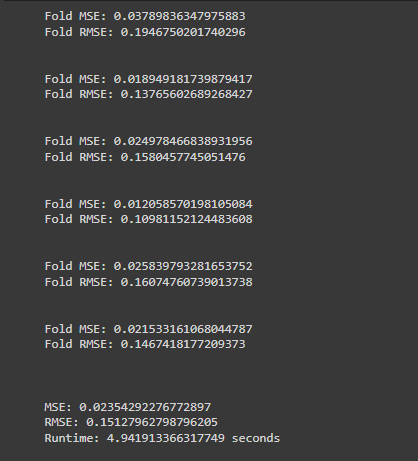

# **PART 3**

In [28]:
df = pd.read_csv("audit_risk.csv")

problematic_rows = df[~df['LOCATION_ID'].astype(str).str.isdigit()]

# print(problematic_rows)

df.loc[problematic_rows.index, 'LOCATION_ID'] = 0

df['LOCATION_ID'] = pd.to_numeric(df['LOCATION_ID'], errors='coerce').fillna(df['LOCATION_ID'])

df.dropna(inplace=True)

X = df.drop(["Risk"], axis=1)
y = df["Risk"]

RESULTS:

K-Fold Cross Validation Results: [0.9922480620155039, 0.9844961240310077, 1.0, 0.9844961240310077, 0.9844961240310077, 0.9922480620155039]

Final Accuracy: 0.9896640826873385

Best Threshold: 0.6079222380602799


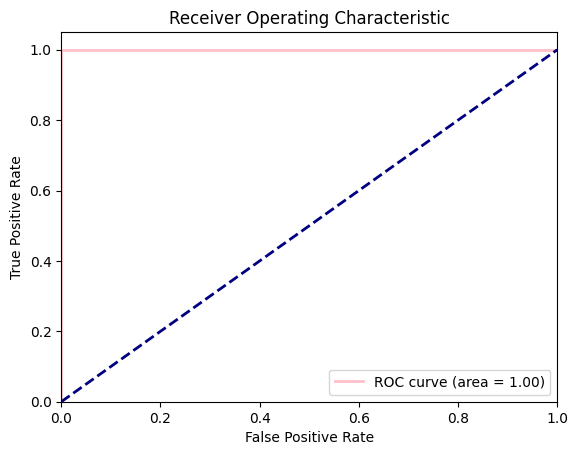

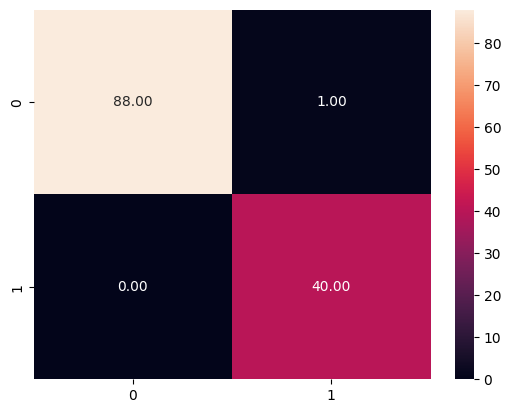



Runtime: 0.6098411083221436 seconds


In [29]:
start_time = time.time()

print("RESULTS:\n")

# Train the model with linear SVM
svm_model = SVC(kernel='linear', probability=True)

folds = k_fold_cross_validation(X.values, y.values, 6)

roc_auc_scores = []
confusion_matrices = []
scores = []

for i, fold in enumerate(folds):
    X_train, y_train, X_test, y_test = fold

    svm_model.fit(X_train, y_train)

    predictions = svm_model.predict(X_test)
    y_prob = svm_model.predict_proba(X_test)[:, 1]

    accuracy = np.mean(predictions == y_test)
    scores.append(accuracy)

    #roc_auc_scores.append(roc_auc_score(y_test, y_prob))
    confusion_matrices.append(confusion_matrix(y_test, predictions))
    #print(confusion_matrices)

final_accuracy = np.mean(scores)
print("K-Fold Cross Validation Results:", scores)
print("\nFinal Accuracy:", final_accuracy)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
#print(roc_auc)

# Find the best threshold
thr = tpr - fpr
best_threshold_index = np.argmax(thr)
best_threshold = thresholds[best_threshold_index]

print("\nBest Threshold:", best_threshold)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='pink', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Display the confusion matrix
sns.heatmap(confusion_matrices[-1], annot=True, fmt='.2f')
plt.show()

end_time = time.time()

# Report runtime performance
runtime = end_time - start_time
print("\n\nRuntime:", runtime, "seconds")

# **COMMENTS:**

Building a classifier based on the linear SVM. (`svm_model = SVC(kernel='linear', probability=True)`)

*Preprocess part is same with KNN Classifier.*

**Traning and Testing:**

This part performs k-fold cross-validation using my implementation, splitting the data into training and testing sets. Within the loop for each fold, it fits the SVM model to the training data and makes predictions on the testing data. Also for each fold the I calculated accuracy, and confusion matrix.

After completing cross-validation, I computed the average accuracy, plotted the ROC curve and displayed the confusion matrix. I also found the best threshold for classification based on the ROC curve.


*   To find the best threshold, the code calculates the difference between the true positive rate and false positive rate (`TPR - FPR`) for each threshold. The threshold that maximizes this difference is chosen as the best threshold. This approach aims to find the optimal balance between sensitivity (true positive rate) and specificity (true negative rate) for the SVM model.

When we look at the results:

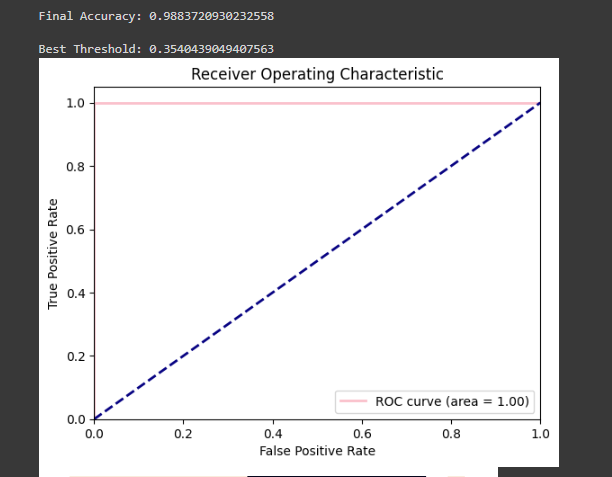

When the ROC curve area is 1, it means the model has perfect discrimination ability, meaning it can perfectly separate the positive and negative classes without any errors. This is an ideal scenario indicating that the model makes correct predictions for all instances in the dataset. However, achieving an AUC of 1 is rare in practice and often indicates overfitting or an issue with the evaluation process.







# **PART 4**

In [30]:
from sklearn.svm import SVR

df_day = pd.read_csv("day.csv")

df_day = df_day.drop(columns=['dteday', 'instant'])

# print(df_day.info())

# Split data into training and test set
X = df_day.drop(["cnt"], axis=1)
y = df_day["cnt"]

In [31]:
start_time = time.time()

svr_regressor = SVR(kernel='linear')

folds = k_fold_cross_validation(X.values, y.values, 6)

print("RESULTS:\n")

mse_scores = []
rmse_scores = []

# Perform SVR with each fold
for fold in folds:
    X_train, y_train, X_test, y_test = fold
    svr_regressor.fit(X_train, y_train)

    # Make predictions on the testing set
    predictions = svr_regressor.predict(X_test)
    # print(predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

    print("Fold MSE:", mse)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_scores.append(rmse)

# Calculate average MSE across all folds
avg_mse = np.mean(mse_scores)
print("Average Mean Squared Error:", avg_mse)

avg_rmse = np.mean(rmse_scores)
print("Average Root Mean Squared Error:", avg_rmse)

end_time = time.time()

# Report runtime performance
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

RESULTS:

Fold MSE: 0.004253114671850935
Fold MSE: 0.00479215655229365
Fold MSE: 0.0049269475535116585
Fold MSE: 0.003997535871996494
Fold MSE: 0.004487340684172492
Fold MSE: 0.004388912787360531
Average Mean Squared Error: 0.004474334686864294
Average Root Mean Squared Error: 0.06684934770454708
Runtime: 0.42110633850097656 seconds


# **COMMENTS:**

Build a regressor based on the linear SVM. (`svr_regressor = SVR(kernel='linear')`)

*Preprocess part is same with KNN Regressor.*

**Traning and Testing:**

This part performs k-fold cross-validation using my implementation, splitting the data into training and testing sets. Within the loop for each fold, it fits the SVM model to the training data and makes predictions on the testing data. Also for each fold the I calculated MSE and RMSE.

After completing cross-validation, I computed the average MSE and RMSE. These values lower than KNN Regressor so, SVM regressor might be a better model for this dataset.

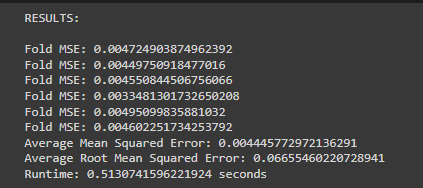

# **PART 5**

In [32]:
df = pd.read_csv("audit_risk.csv")

problematic_rows = df[~df['LOCATION_ID'].astype(str).str.isdigit()]

# print(problematic_rows)

df.loc[problematic_rows.index, 'LOCATION_ID'] = 0

df['LOCATION_ID'] = pd.to_numeric(df['LOCATION_ID'], errors='coerce').fillna(df['LOCATION_ID'])

df.dropna(inplace=True)

X = df.drop(["Risk"], axis=1)
y = df["Risk"]

RESULTS:

K-Fold Cross Validation Results: [0.8527131782945736, 0.8992248062015504, 0.8914728682170543, 0.9302325581395349, 0.8604651162790697, 0.813953488372093]

Final Accuracy: 0.8746770025839793
Best Threshold: 0.1923636292664795


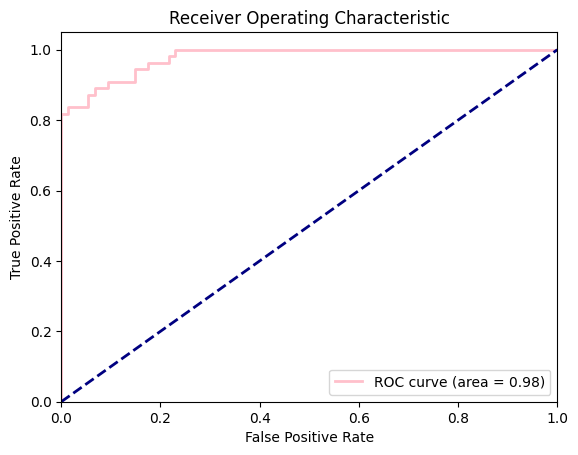

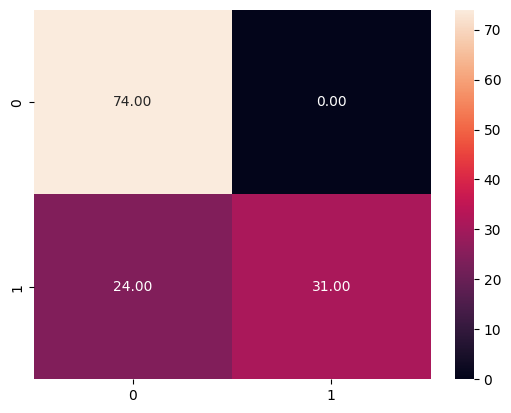

Runtime: 0.576812744140625 seconds


In [33]:
start_time = time.time()

print("RESULTS:\n")
# Train the model with rbf SVM
svm_model = SVC(kernel='rbf', random_state=42, probability=True)

folds = k_fold_cross_validation(X.values, y.values, 6)

roc_auc_scores = []
confusion_matrices = []
scores = []

for i, fold in enumerate(folds):
    X_train, y_train, X_test, y_test = fold

    svm_model.fit(X_train, y_train)

    predictions = svm_model.predict(X_test)
    y_prob = svm_model.predict_proba(X_test)[:, 1]

    accuracy = np.mean(predictions == y_test)
    scores.append(accuracy)

    # roc_auc_scores.append(roc_auc_score(y_test, y_prob))
    confusion_matrices.append(confusion_matrix(y_test, predictions))
    #print(confusion_matrices)

final_accuracy = np.mean(scores)
print("K-Fold Cross Validation Results:", scores)
print("\nFinal Accuracy:", final_accuracy)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Find the best threshold
thr = tpr - fpr
best_threshold_index = np.argmax(thr)
best_threshold = thresholds[best_threshold_index]

print("Best Threshold:", best_threshold)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='pink', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Display the confusion matrix
sns.heatmap(confusion_matrices[-1], annot=True, fmt='.2f')
plt.show()

end_time = time.time()

# Report runtime performance
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

# **COMMENTS:**

 Build a classifier based on the radial basis function SVM.  (`SVC(kernel='rbf', random_state=42, probability=True)`)



*   Linear SVMs are simpler and faster but are limited to linear decision boundaries, while RBF SVMs can capture complex relationships but require more computational resources.




*Preprocess part is same with KNN Classifier.*

**Traning and Testing:**

This part performs k-fold cross-validation using my implementation, splitting the data into training and testing sets. Within the loop for each fold, it fits the SVM model to the training data and makes predictions on the testing data. Also for each fold the I calculated accuracy, and confusion matrix.

After completing cross-validation, I computed the average accuracy, plotted the ROC curve and displayed the confusion matrix. I also found the best threshold for classification based on the ROC curve.

When we look at the results:

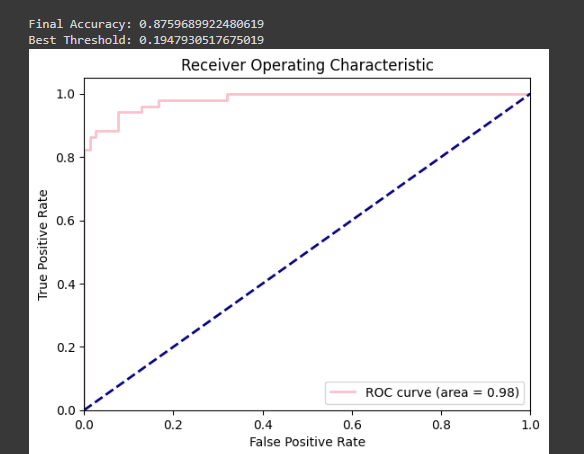

So, when we compare with linear SVM, the accuracy is lower in RBF SVM. The RBF SVM might be overfitting the training data. The increased complexity of the RBF kernel allows the model to capture more complicated patterns in the training data, but this can lead to poorer generalization performance on unseen data if the model becomes too tailored to the training set.


# **PART 6**

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn import tree
from sklearn.tree import _tree

def pre_pruned_decision_tree(X_train, y_train, max_depth=None, min_samples_leaf=1):
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1234)
    clf.fit(X_train, y_train)
    return clf

In [35]:
def tree_to_rules(clf, feature_names):
    extracted_tree = clf.tree_ # tree_ is a specific instance of a dt model, which includes information like feature indices, thresholds, and node values.

    feature_name = []

    for i in extracted_tree.feature:
        if i != _tree.TREE_UNDEFINED: # _tree provides low-level access to the internals of decision trees.
            feature_name.append(feature_names[i])
        else:
            feature_name.append("undefined!")


    def traverse(node):
        if extracted_tree.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = extracted_tree.threshold[node]

            # Left node
            print(f"{name} <= {threshold:.2f}")
            traverse(extracted_tree.children_left[node])

            # Right node
            print(f"{name} > {threshold:.2f}")
            traverse(extracted_tree.children_right[node])
        else:
            print(f"Values: {extracted_tree.value[node]}\n")

    traverse(0)

In [36]:

def k_fold_cross_validation_dt(X, y, k, pruning_strategy, **kwargs):
    num_of_samples = len(X)
    fold_size = num_of_samples // k

    indices = np.random.permutation(num_of_samples)
    X_mixed = X[indices]
    y_mixed = y[indices]

    scores = []
    rules = []

    for i in range(k):
        X_test = X_mixed[i * fold_size:(i + 1) * fold_size]
        y_test = y_mixed[i * fold_size:(i + 1) * fold_size]

        X_train = np.concatenate([X_mixed[:i * fold_size], X_mixed[(i + 1) * fold_size:]])
        y_train = np.concatenate([y_mixed[:i * fold_size], y_mixed[(i + 1) * fold_size:]])

        if pruning_strategy == 'pre_pruned':
            clf = pre_pruned_decision_tree(X_train, y_train, **kwargs)
        elif pruning_strategy == 'post_pruned':
            #clf = post_pruned_decision_tree(X_train, y_train, X_test, y_test)
            clf = DecisionTreeClassifier(ccp_alpha=0.003, random_state=12)
            clf.fit(X_train, y_train)
        else:
            raise ValueError("Choose 'pre_pruned' or 'post_pruned'.")

        scores.append(accuracy_score(y_test, clf.predict(X_test)))

    # Print rules from tree_to_rules function
    X_df = pd.DataFrame(X, columns=df.columns[:-1])
    rules = tree_to_rules(clf, X_df.columns)

    return scores

In [37]:
df = pd.read_csv("audit_risk.csv")

# Step 1: Identify problematic rows
problematic_rows = df[~df['LOCATION_ID'].astype(str).str.isdigit()]

# print(problematic_rows)

df.loc[problematic_rows.index, 'LOCATION_ID'] = 0

df['LOCATION_ID'] = pd.to_numeric(df['LOCATION_ID'], errors='coerce').fillna(df['LOCATION_ID'])

df.dropna(inplace=True)

X = df.drop(["Risk"], axis=1)
y = df["Risk"]



In [38]:
print("RESULTS: \n")

start_time = time.time()
print("Pre-pruning:\n")
pre_pruned_scores = k_fold_cross_validation_dt(X.values, y.values, k=6, pruning_strategy='pre_pruned', max_depth=10, min_samples_leaf=5)
print("Post-pruning:\n")
post_pruned_scores = k_fold_cross_validation_dt(X.values, y.values, k=6, pruning_strategy='post_pruned')

print("Pre-pruned Decision Tree Accuracy:", np.mean(pre_pruned_scores))
print("Post-pruned Decision Tree Accuracy:", np.mean(post_pruned_scores))

end_time = time.time()

# Report runtime performance
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

RESULTS: 

Pre-pruning:

Audit_Risk <= 1.00
Values: [[393.   0.]]

Audit_Risk > 1.00
Values: [[  0. 253.]]

Post-pruning:

Audit_Risk <= 1.00
Values: [[390.   0.]]

Audit_Risk > 1.00
Values: [[  0. 256.]]

Pre-pruned Decision Tree Accuracy: 1.0
Post-pruned Decision Tree Accuracy: 1.0
Runtime: 0.02346944808959961 seconds


# **COMMENTS:**

Build a classifier based on DT.

*Preprocess part is same with KNN Classifier.*

\\

**Convert tree to rules:**

The tree_to_rules function is designed to extract rules from a decision tree.

Through a recursive traversal, starting from the root node, the function navigates through the tree, printing out rules feature names and thresholds at each node. When encountering a split node, it generates rules in the form of "`feature_name <= threshold`" for the left child and "`feature_name > threshold`" for the right child, like the decision logic of the tree.

If a node is a leaf node, it prints the node's values. At the end by calling the traverse function, it starts the traversal from the root node (index 0).

\\

**K-Fold Implementation:**

In here, I used kind of different k-fold implementation from other models because of pruning strategy. The different parts are:


*   I made an if-else block to understand that are we going to use pre pruning or post pruning.
*   I called the `tree_to_rules` function for taking the clf and X features as parameters easier.
*   I trained, fitted and made predictions inside of this function.

\\

**Pruning Strategies:**


*   Pre-Pruning: It sets constraints on tree growth during construction. By specifying parameters such as max_depth and min_samples_leaf, I told the decision tree to stop growing beyond a certain depth and to create leaf nodes only when a minimum number of samples are present.

*   Post-Pruning: It grows a full decision tree first and then prunes it back.  I've employed post-pruning by setting the ccp_alpha parameter. This parameter represents the cost complexity of the tree, and pruning is performed based on minimizing this cost.

\\

**Training and Testing:**

I called 2 different k-fold cross validation for pruning strategies. So, I trained, fitted and made predictions inside of that function.

\\

When we look at the results:

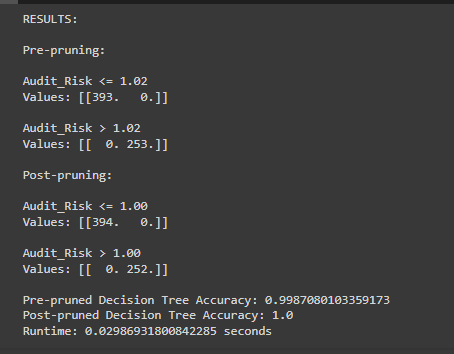

The accuracy is 1 or too high. This shows the model may memorized the dataset which may caused an overfitting.


# **PART 7**

In [39]:
from sklearn.tree import DecisionTreeRegressor

df_day = pd.read_csv("day.csv")

df_day = df_day.drop(columns=['dteday', 'instant'])

# Split data into training and test set
X = df_day.drop(["cnt"], axis=1)
y = df_day["cnt"]

In [41]:
start_time = time.time()
print("RESULTS: \n")
folds = k_fold_cross_validation(X.values, y.values, 6)

mse_scores = []
rmse_scores = []

for fold in folds:
    X_train, y_train, X_test, y_test = fold

    # Create and train the model
    # dt_regressor = DecisionTreeRegressor(max_depth=5, min_samples_leaf=7, random_state=1234)
    dt_regressor = DecisionTreeRegressor()
    dt_regressor.fit(X_train, y_train)

    # Make predictions on the testing set
    predictions = dt_regressor.predict(X_test)
    # print(predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

    #print("Fold MSE:", mse)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_scores.append(rmse)

# Calculate average MSE across all folds
avg_mse = np.mean(mse_scores)
print("Average Mean Squared Error:", avg_mse)

avg_rmse = np.mean(rmse_scores)
print("Average Root Mean Squared Error:", avg_rmse)

end_time = time.time()

# Report runtime performance
runtime = end_time - start_time
print("Runtime:", runtime, "seconds")

# Print rules
text_representation = tree.export_text(dt_regressor)
print("\nRules:")
print(text_representation)


RESULTS: 

Average Mean Squared Error: 42614.78650137741
Average Root Mean Squared Error: 203.88061996397732
Runtime: 0.040444374084472656 seconds

Rules:
|--- feature_12 <= 3905.50
|   |--- feature_12 <= 2304.50
|   |   |--- feature_12 <= 1392.00
|   |   |   |--- feature_12 <= 909.50
|   |   |   |   |--- feature_11 <= 48.00
|   |   |   |   |   |--- feature_4 <= 1.50
|   |   |   |   |   |   |--- value: [22.00]
|   |   |   |   |   |--- feature_4 >  1.50
|   |   |   |   |   |   |--- feature_8 <= 0.23
|   |   |   |   |   |   |   |--- feature_8 <= 0.21
|   |   |   |   |   |   |   |   |--- value: [506.00]
|   |   |   |   |   |   |   |--- feature_8 >  0.21
|   |   |   |   |   |   |   |   |--- feature_10 <= 0.22
|   |   |   |   |   |   |   |   |   |--- value: [431.00]
|   |   |   |   |   |   |   |   |--- feature_10 >  0.22
|   |   |   |   |   |   |   |   |   |--- value: [441.00]
|   |   |   |   |   |   |--- feature_8 >  0.23
|   |   |   |   |   |   |   |--- feature_4 <= 3.00
|   |   |   |   |

# **COMMENTS:**

Build a regressor based on DT.

*Preprocess part is same with KNN Regressor.*

\\

**Traning and Testing:**

This part performs k-fold cross-validation using my implementation, splitting the data into training and testing sets. Within the loop for each fold, it fits the DT model to the training data and makes predictions on the testing data. Also for each fold the I calculated MSE and RMSE.

After completing cross-validation, I computed the average MSE and RMSE.

When we look at the results:

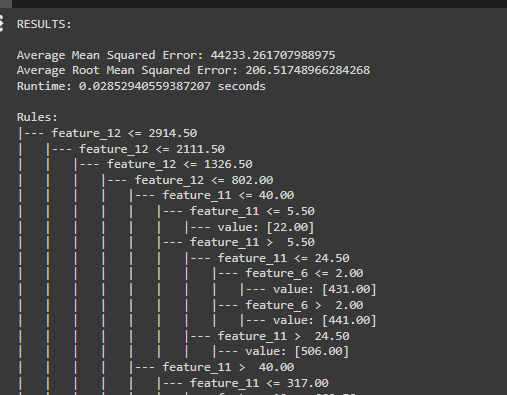

We can see that those MSE and RMSE values are relatively high when we compare it by KNN or SVM regressor. That's why I tried hyperparameter tuning and post-pruning but they didn't effect much:

`dt_regressor = DecisionTreeRegressor(max_depth=5, min_samples_leaf=7, random_state=1234)`

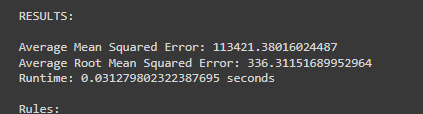

In summary, based on these metrics, the KNN and SVM regressors appear to be performing significantly better than the decision tree regressor on this dataset and preprocessing. The KNN and SVM model demonstrates much lower errors, suggesting it provides more accurate predictions.